In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM

In [2]:
import pandas as pd
import numpy as np

train_df = pd.read_csv("part-00000")
val_df = pd.read_csv("./validation/part-00000")

train = train_df.to_numpy()
val = val_df.to_numpy()

train_labels = train[:,0]
train_timestamps = train[:,1]
train_data = train[:,2:]

val_labels = val[:,0]
val_timestamps = val[:,1]
val_data = val[:,2:]

In [3]:
import torch
import torch.nn as nn

def create_input_sequence(input_data, input_labels, timestamps):

    input_data = torch.tensor(input_data, dtype=torch.float32)
    input_labels = torch.tensor(input_labels, dtype=torch.float32)
    
    max_timestamp = int(max(timestamps))

    train_sequence = [[] for i in range(max_timestamp+1)]
    train_labels = [0 for i in range(max_timestamp+1)]

    for i in range(len(input_data)):
        timestamp = int(timestamps[i])
        train_sequence[timestamp].append(input_data[i])
        train_labels[timestamp] = input_labels[i]

    for i in range(len(train_sequence)):
        if train_sequence[i]:
            train_sequence[i] = torch.stack(train_sequence[i], dim=0)
    
    # print(train_sequence)
    #Calculate mean of each timestep, could try to use encoder-decoder 
    for i in range(len(train_sequence)):
        train_sequence[i] = torch.mean(train_sequence[i], dim=0)
    
    # #First pad, since the data entries in each week is different.
    # #pad_train_sequence = pad_sequence(train_sequence)

    train_sequence = torch.stack(train_sequence)
    train_labels = torch.stack(train_labels, dim=0)
    # train_labels = train_labels.view(-1,1)

    return train_sequence, train_labels

In [4]:
data_x, data_y = create_input_sequence(train_data, train_labels, train_timestamps)

#Should NOT normalize validation data?
data_x = (data_x - data_x.mean(axis=0)) / data_x.std(axis=0)
data_y = (data_y - data_y.mean(axis=0)) / data_y.std(axis=0)

In [5]:
data_x = data_x.cpu().detach().numpy()
data_y = data_y.cpu().detach().numpy()

train_size = len(data_x) // 4 * 3

train_x, train_y = data_x[:train_size], data_y[:train_size]
val_x, val_y = data_x[train_size:], data_y[train_size:]

In [6]:
time_steps = 20

batch_x = []
batch_y = []

for i in range(time_steps, len(train_x)):
    batch_x.append(train_x[i-time_steps:i])
    batch_y.append(train_y[i])

batch_x, batch_y = np.array(batch_x), np.array(batch_y)

In [19]:
batch_val_x = []

for i in range(time_steps, len(data_x)):
    batch_val_x.append(data_x[i-time_steps:i])

batch_val_x = np.array(batch_val_x)

In [8]:
batch_val_x.shape

(20, 20, 36)

In [9]:
step_size = 1

model = Sequential()
model.add(LSTM(32, input_shape=(time_steps,36), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

In [10]:
model.compile(loss='mean_squared_error', optimizer='adam') # Try SGD, adam, adagrad and compare!!!
model.fit(batch_x, batch_y, epochs=20, batch_size=1, verbose=2)

Epoch 1/20
91/91 - 17s - loss: 1.1886
Epoch 2/20
91/91 - 1s - loss: 1.0825
Epoch 3/20
91/91 - 1s - loss: 1.0599
Epoch 4/20
91/91 - 1s - loss: 1.0214
Epoch 5/20
91/91 - 1s - loss: 0.9810
Epoch 6/20
91/91 - 1s - loss: 0.9632
Epoch 7/20
91/91 - 1s - loss: 0.9195
Epoch 8/20
91/91 - 1s - loss: 0.8916
Epoch 9/20
91/91 - 1s - loss: 0.8647
Epoch 10/20
91/91 - 1s - loss: 0.7828
Epoch 11/20
91/91 - 1s - loss: 0.7173
Epoch 12/20
91/91 - 1s - loss: 0.6448
Epoch 13/20
91/91 - 1s - loss: 0.5794
Epoch 14/20
91/91 - 1s - loss: 0.4897
Epoch 15/20
91/91 - 1s - loss: 0.4068
Epoch 16/20
91/91 - 1s - loss: 0.3003
Epoch 17/20
91/91 - 1s - loss: 0.2516
Epoch 18/20
91/91 - 1s - loss: 0.1842
Epoch 19/20
91/91 - 1s - loss: 0.1483
Epoch 20/20
91/91 - 1s - loss: 0.1171


In [20]:
pred = model.predict(batch_val_x)

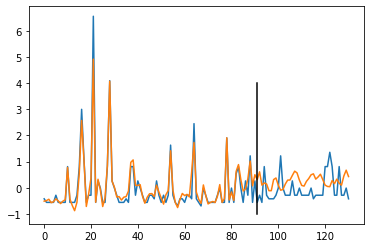

In [25]:
import matplotlib.pyplot as plt

train_size = len(data_x) // 4 * 3

plt.plot(data_y[20:])
plt.plot(pred)
plt.plot([train_size-20, train_size-20], [-1, 4], color='k', label='train | pred')
plt.show()